In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding,
                                     Flatten, Activation, SimpleRNN, GRU, LSTM, Bidirectional, Conv1D,
                                     MaxPooling1D, GlobalMaxPooling1D, Input, Concatenate)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import plot_model
import gdown
import warnings
warnings.filterwarnings('ignore')

In [ ]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

data16_17 = pd.read_csv('16_17.csv', sep=';')[['DATE', 'TIME', 'CLOSE']][-10000:]
data18_19 = pd.read_csv('18_19.csv', sep=';')[['DATE', 'TIME', 'CLOSE']][:10000]
data = pd.concat([data16_17, data18_19])

data['DATETIME'] = pd.to_datetime(data['DATE'] + ' ' + data['TIME'])
data.drop(columns=['DATE', 'TIME'], inplace=True)
data.set_index('DATETIME', inplace=True)

# Доп. столбцы изменения Close (diff)
IND_DEPTH = 10
for i in range(1, IND_DEPTH + 1):
    data[f'diff_{i}'] = data['CLOSE'].diff(i)
data.dropna(inplace=True)

display(data.describe()[['CLOSE']].loc[['min', 'max']],
        data[500:505])
display(data.info())
data = data.to_numpy()
display(data.shape)

,CLOSE
min,3262.5
max,3979.0


,CLOSE,diff_1,diff_2,diff_3,diff_4,diff_5,diff_6,diff_7,diff_8,diff_9,diff_10
DATETIME,,,,,,,,,,,
2017-05-12 17:31:00,3385.5,6.0,-6.5,-4.5,-4.0,-5.0,-6.5,-4.0,-4.0,-2.5,-6.5
2017-05-12 17:32:00,3383.0,-2.5,3.5,-9.0,-7.0,-6.5,-7.5,-9.0,-6.5,-6.5,-5.0
2017-05-12 17:33:00,3386.0,3.0,0.5,6.5,-6.0,-4.0,-3.5,-4.5,-6.0,-3.5,-3.5
2017-05-12 17:34:00,3387.0,1.0,4.0,1.5,7.5,-5.0,-3.0,-2.5,-3.5,-5.0,-2.5
2017-05-12 17:35:00,3387.0,0.0,1.0,4.0,1.5,7.5,-5.0,-3.0,-2.5,-3.5,-5.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19990 entries, 2017-04-12 17:54:00 to 2018-01-31 10:48:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CLOSE    19990 non-null  float64
 1   diff_1   19990 non-null  float64
 2   diff_2   19990 non-null  float64
 3   diff_3   19990 non-null  float64
 4   diff_4   19990 non-null  float64
 5   diff_5   19990 non-null  float64
 6   diff_6   19990 non-null  float64
 7   diff_7   19990 non-null  float64
 8   diff_8   19990 non-null  float64
 9   diff_9   19990 non-null  float64
 10  diff_10  19990 non-null  float64
dtypes: float64(11)
memory usage: 1.8 MB


None

(19990, 11)

## Функции

In [ ]:
# Обработка и подготовка данных
def create_data(data, val_len=1300, steps_forward=1, SEQ_LEN=300, BATCH_SIZE=5):
    train_len = data.shape[0] - val_len   # тренировочная выборка
    if steps_forward > 1:
        train, test = data[:train_len-steps_forward], \
                    data[train_len+SEQ_LEN+2:-steps_forward+1]
    if steps_forward == 1:
        train, test = data[:train_len-steps_forward], \
                    data[train_len+SEQ_LEN+2:-1]
    print('train, test:', train.shape, test.shape)

    # отдельно Close для Train
    x_close_train = train[:, 0].reshape(-1, 1) # нулевой столбец
    x_close_test = test[:, 0].reshape(-1, 1)
    x_close_scaler = MinMaxScaler()
    x_close_train_scaled = x_close_scaler.fit_transform(x_close_train) # fit
    x_close_test_scaled = x_close_scaler.transform(x_close_test)

    # отдельно Diff... для Train
    x_diff_train = train[:, 1:] # столбец с 1-го по последний
    x_diff_test = test[:, 1:]
    x_diff_scaler = StandardScaler()
    x_diff_train_scaled = x_diff_scaler.fit_transform(x_diff_train) # fit
    x_diff_test_scaled = x_diff_scaler.transform(x_diff_test)

    # np.hstack для X (Close + diff...)
    x_train_scaled = np.hstack((x_close_train_scaled, x_diff_train_scaled))
    x_test_scaled = np.hstack((x_close_test_scaled, x_diff_test_scaled))
    print('x_train_scaled, x_test_scaled', x_train_scaled.shape, x_test_scaled.shape)

    if steps_forward > 1: # Y - срез от текущего до steps_forward шагов вперед по CLOSE (0-й столбец)
        y_train = np.array([data[:train_len, 0][i:i+steps_forward] for i in range(train_len-steps_forward)])
        y_test = np.array([data[train_len+SEQ_LEN+2:, 0][i:i+steps_forward] for i in range(val_len-SEQ_LEN-steps_forward-1)])
    if steps_forward == 1:
        y_train = x_close_train
        y_test = x_close_test
    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    print('y_train_scaled, y_test_scaled', y_train_scaled.shape, y_test_scaled.shape)

    return x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, y_scaler


# Генераторы
def data_gen(x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, SEQ_LEN, BATCH_SIZE):
    # Train генератор
    train_datagen = TimeseriesGenerator(x_train_scaled, y_train_scaled,
                                        length=SEQ_LEN, stride=1, sampling_rate=1,
                                        batch_size=BATCH_SIZE)
    print('train_datagen X, Y:',
        train_datagen[0][0].shape,
        train_datagen[0][1].shape)
    # Test генератор
    test_datagen = TimeseriesGenerator(x_test_scaled, y_test_scaled,
                                       length=SEQ_LEN, stride=1, sampling_rate=1,
                                       batch_size=BATCH_SIZE)
    print('test_datagen X, Y:',
        test_datagen[0][0].shape,
        test_datagen[0][1].shape)

    return train_datagen, test_datagen

# x, y для удобства проверки
def get_data_test(x_scaled, y_scaled, SEQ_LEN):
    datagen = TimeseriesGenerator(x_scaled, y_scaled,
                                  length=SEQ_LEN, sampling_rate=1,
                                  batch_size=x_scaled.shape[0])
    x, y = [], []
    for i in datagen:
        x.append(i[0])
        y.append(i[1])
    x = np.array(x)
    y = np.array(y)
    print('x[0]:', x[0].shape)
    print('y[0]:', y[0].shape)
    return x, y


def draw_loss(history):
    plt.subplots(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train mse')
    plt.plot(history.history['val_loss'], label='Test mse')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]


def get_pred(model, x, y, y_scaler):
    y_pred = y_scaler.inverse_transform(model.predict(x))
    y_test = y_scaler.inverse_transform(y)
    return y_pred, y_test


# Графики Цены
def show_predict(start, step, channel, y_pred_val, y_val):
    plt.subplots(figsize=(10, 5))
    plt.plot(y_pred_val[start:start+step, channel], label=f'Прогноз (канал: {channel})')
    plt.plot(y_val[start:start+step, channel], label='Факт')
    plt.xlabel('Время')
    plt.ylabel('Close')
    plt.legend()
    plt.show()


def show_corr(channels, corr_steps, y_pred_val, y_val):
    plt.subplots(figsize=(10, 5))
    for ch in channels:
        corr = []
        y_len = y_val.shape[0]
        for i in range(corr_steps):
            corr.append(correlate(y_val[:y_len-i, ch], y_pred_val[i:, ch]))
        own_corr = []
        for i in range(corr_steps):
            own_corr.append(correlate(y_val[:y_len-i, ch], y_val[i:, ch]))
        plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

## Модели

### Предсказание на 1 шаг

train, test: (18689, 11) (997, 11)
x_train_scaled, x_test_scaled (18689, 11) (997, 11)
y_train_scaled, y_test_scaled (18689, 1) (997, 1)
train_datagen X, Y: (5, 300, 11) (5, 1)
test_datagen X, Y: (5, 300, 11) (5, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 300, 100)          1200      
                                                                 
 dense_10 (Dense)            (None, 300, 20)           2020      
                                                                 
 flatten_3 (Flatten)         (None, 6000)              0         
                                                                 
 dense_11 (Dense)            (None, 1)                 6001      
                                                                 
Total params: 9221 (36.02 KB)
Trainable params: 9221 (36.02 KB)
Non-trainable params: 0 (0.00 Byte)
__

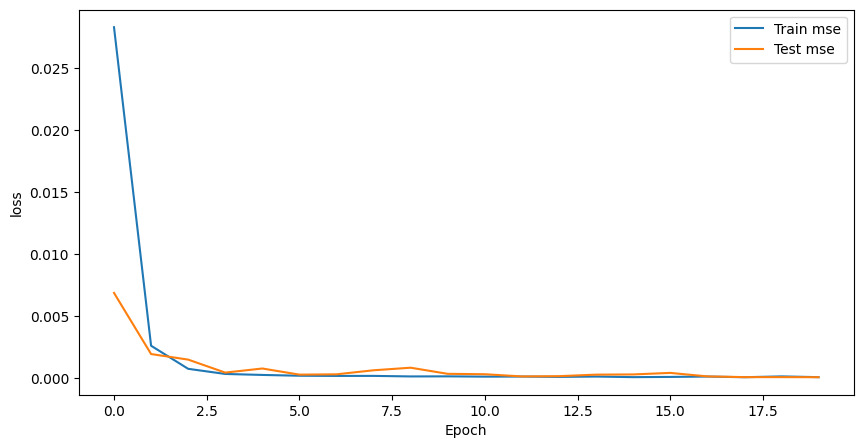

x[0]: (697, 300, 11)
y[0]: (697, 1)
22/22 [==============================] - 0s 4ms/step
(697, 1) (697, 1)


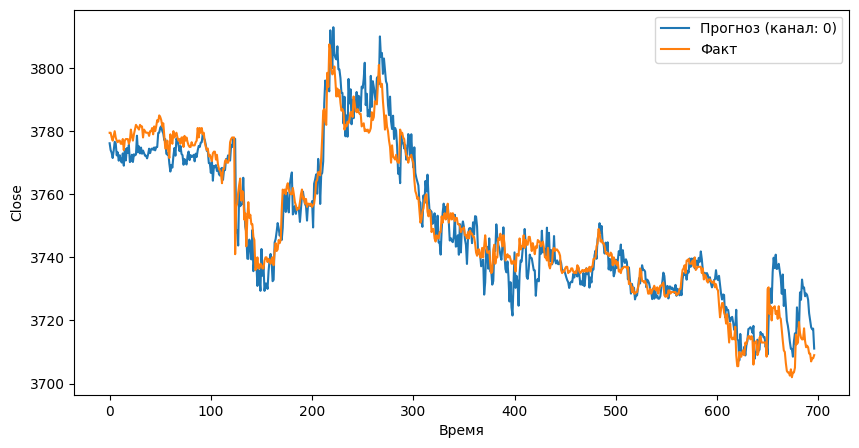

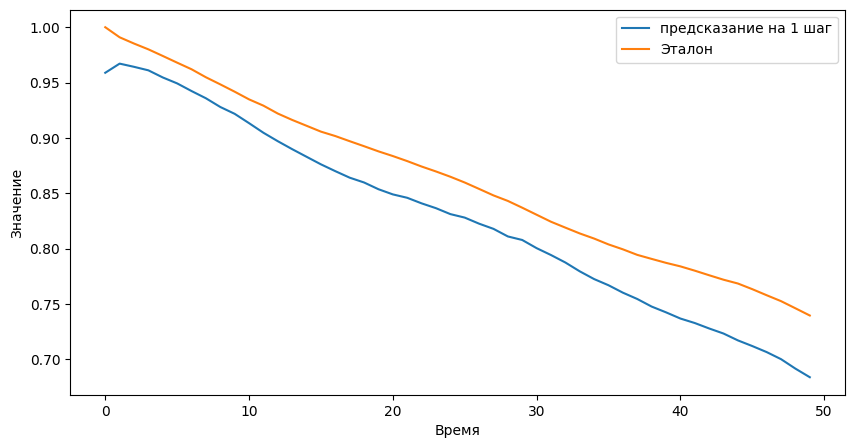

In [ ]:
steps_forward = 1    # шаг предсказания
val_len = 1300       # тест выборка (включая разрыв)
SEQ_LEN = 300
BATCH_SIZE = 5

x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, y_scaler = \
create_data(data, val_len, steps_forward, SEQ_LEN, BATCH_SIZE)

train_datagen, test_datagen = \
data_gen(x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, SEQ_LEN, BATCH_SIZE)

# Dense ----------------------------------
model = Sequential()
model.add(Dense(100, input_shape=(train_datagen[0][0].shape[1:]), activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Flatten())
model.add(Dense(train_datagen[0][1].shape[1], activation='linear'))
# ----------------------------------------

model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))

history = model.fit(train_datagen,
                    epochs=20,
                    verbose=0,
                    validation_data = test_datagen)
model.summary()
draw_loss(history)
x_gen, y_gen = get_data_test(x_test_scaled, y_test_scaled, SEQ_LEN)
y_pred_val, y_val = get_pred(model, x_gen[0], y_gen[0], y_scaler)
print(y_pred_val.shape, y_val.shape)
show_predict(0, 697, 0, y_pred_val, y_val)
show_corr([0], 50, y_pred_val, y_val)

Предсказание на 10 шагов

train, test: (18680, 11) (989, 11)
x_train_scaled, x_test_scaled (18680, 11) (989, 11)
y_train_scaled, y_test_scaled (18680, 10) (989, 10)
train_datagen X, Y: (5, 300, 11) (5, 10)
test_datagen X, Y: (5, 300, 11) (5, 10)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 300, 100)          1200      
                                                                 
 dense_13 (Dense)            (None, 300, 20)           2020      
                                                                 
 flatten_4 (Flatten)         (None, 6000)              0         
                                                                 
 dense_14 (Dense)            (None, 10)                60010     
                                                                 
Total params: 63230 (246.99 KB)
Trainable params: 63230 (246.99 KB)
Non-trainable params: 0 (0.00 

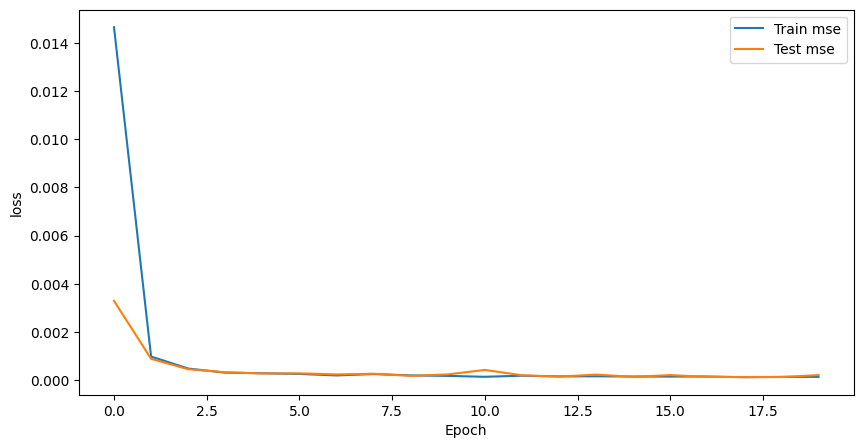

x[0]: (689, 300, 11)
y[0]: (689, 10)
22/22 [==============================] - 0s 4ms/step
(689, 10) (689, 10)


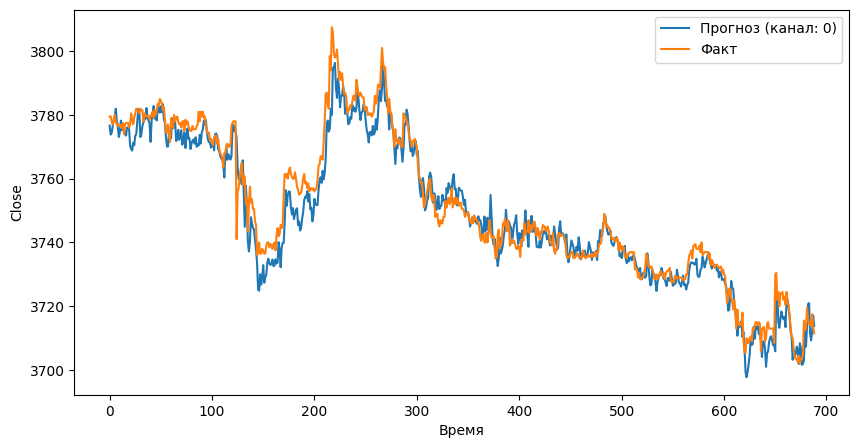

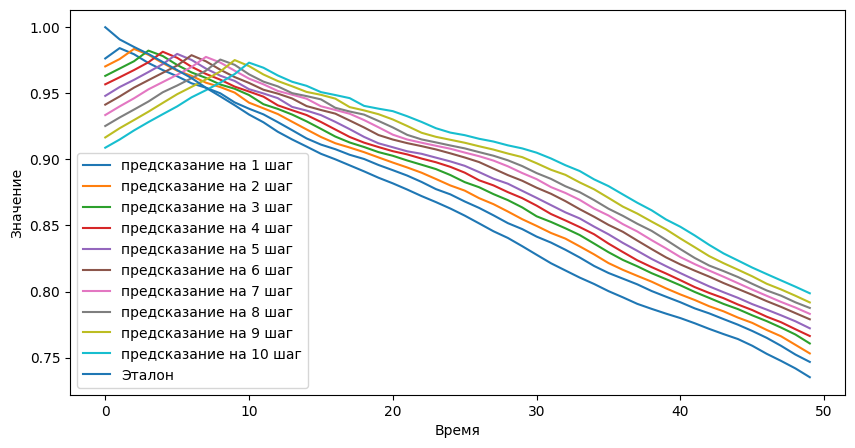

In [ ]:
steps_forward = 10   # шаг предсказания
val_len = 1300       # тест выборка (включая разрыв)
SEQ_LEN = 300
BATCH_SIZE = 5

x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, y_scaler = \
create_data(data, val_len, steps_forward, SEQ_LEN, BATCH_SIZE)

train_datagen, test_datagen = \
data_gen(x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, SEQ_LEN, BATCH_SIZE)

# Dense ----------------------------------
model = Sequential()
model.add(Dense(100, input_shape=(train_datagen[0][0].shape[1:]), activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Flatten())
model.add(Dense(train_datagen[0][1].shape[1], activation='linear'))
# ----------------------------------------

model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))

history = model.fit(train_datagen,
                    epochs=20,
                    verbose=0,
                    validation_data = test_datagen)
model.summary()
draw_loss(history)
x_gen, y_gen = get_data_test(x_test_scaled, y_test_scaled, SEQ_LEN)
y_pred_val, y_val = get_pred(model, x_gen[0], y_gen[0], y_scaler)
print(y_pred_val.shape, y_val.shape)
show_predict(0, 697, 0, y_pred_val, y_val)
show_corr([0,1,2,3,4,5,6,7,8,9], 50, y_pred_val, y_val)

train, test: (18680, 11) (989, 11)
x_train_scaled, x_test_scaled (18680, 11) (989, 11)
y_train_scaled, y_test_scaled (18680, 10) (989, 10)
train_datagen X, Y: (5, 300, 11) (5, 10)
test_datagen X, Y: (5, 300, 11) (5, 10)


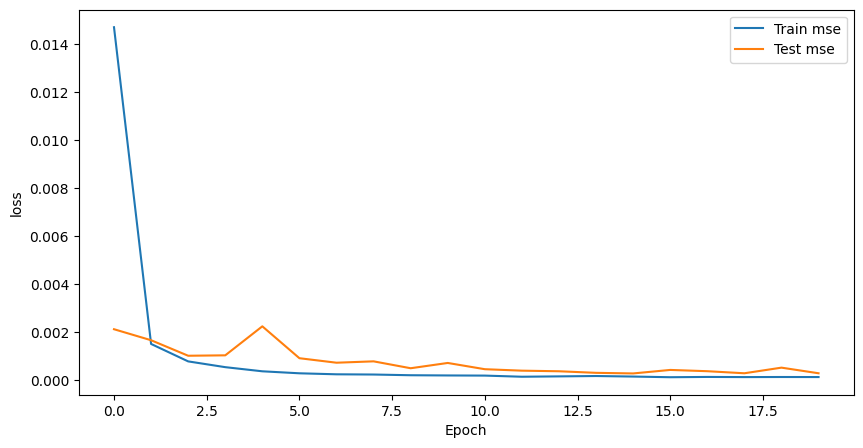

x[0]: (689, 300, 11)
y[0]: (689, 10)
22/22 [==============================] - 1s 12ms/step
(689, 10) (689, 10)


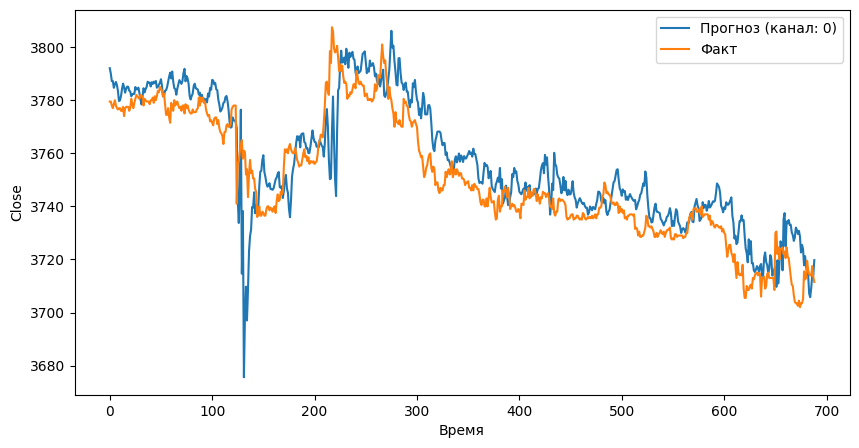

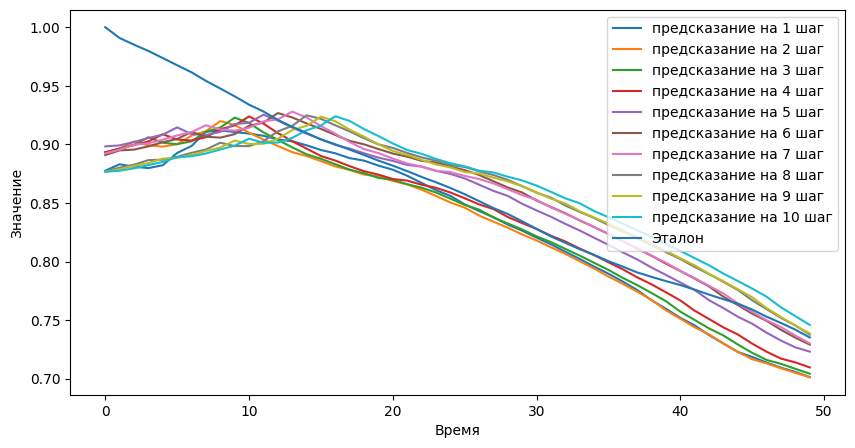

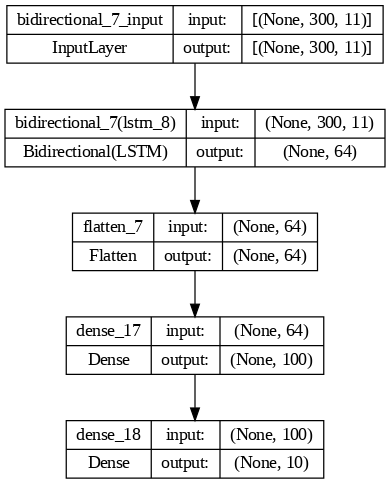

In [ ]:
steps_forward = 10   # шаг предсказания
val_len = 1300       # тест выборка (включая разрыв)
SEQ_LEN = 300
BATCH_SIZE = 5

x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, y_scaler = \
create_data(data, val_len, steps_forward, SEQ_LEN, BATCH_SIZE)

train_datagen, test_datagen = \
data_gen(x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, SEQ_LEN, BATCH_SIZE)

# Bidirectional(LSTM) + Dense ---------------------------
model = Sequential()
model.add(Bidirectional(LSTM(32), input_shape=(train_datagen[0][0].shape[1:])))
model.add(Flatten())
model.add(Dense(100, activation="linear"))
model.add(Dense(train_datagen[0][1].shape[1], activation="linear"))
# -------------------------------------------------------

model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))

history = model.fit(train_datagen,
                    epochs=20,
                    verbose=0,
                    validation_data = test_datagen)

draw_loss(history)
x_gen, y_gen = get_data_test(x_test_scaled, y_test_scaled, SEQ_LEN)
y_pred_val, y_val = get_pred(model, x_gen[0], y_gen[0], y_scaler)
print(y_pred_val.shape, y_val.shape)
show_predict(0, 697, 0, y_pred_val, y_val)
show_corr([0,1,2,3,4,5,6,7,8,9], 50, y_pred_val, y_val)
plot_model(model, dpi=90, show_shapes=True, show_layer_names=True)

# Вывод: На всех моделях присутствуют признаки автокорреляции. Предсказывать абсолютную цену - не эффективно